# Lookup Table Generation for Point Lens Amplification factors
### For broader $y \in (10^{-3}, 10)$
### The settings are given here but whole lookup table is not generated. Instead, only part from (1e-3, 1e-2) is generated and then added to the existing data.

In [1]:
#!/home/anuj.mishra/anaconda3/envs/gwpy/bin/python

import numpy as np

import sys
import mpmath
from mpmath import hyp1f1
import math
import scipy
import pandas as pd

from copy import deepcopy

from itertools import product
from functools import partial
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import pickle

sys.path.append('../src/')
# loading Python version of the point lens class
import pnt_lens_class 
pnt_lens_py = pnt_lens_class.point_lens()

# loading Cython version of the point lens class
import cythonized_pnt_lens_class as pnt_lens_cy


import multiprocessing as mp
npool = 1  # int(sys.argv[1])


G = 6.67430*1e-11 
c = 299792458. 
M_sun = 1.989*1e30

## 1. Bounds on w for lookup table 

In [2]:
w_min, w_max = pnt_lens_cy.w_of_f(10, ml=1e-1), pnt_lens_cy.w_of_f(1024, ml=1e5)
('rough lower and upper limits of w:' , w_min, w_max )

('rough lower and upper limits of w:',
 0.00012382782869256283,
 12679.969658118436)

## 3. Grid Generation

40000 15000


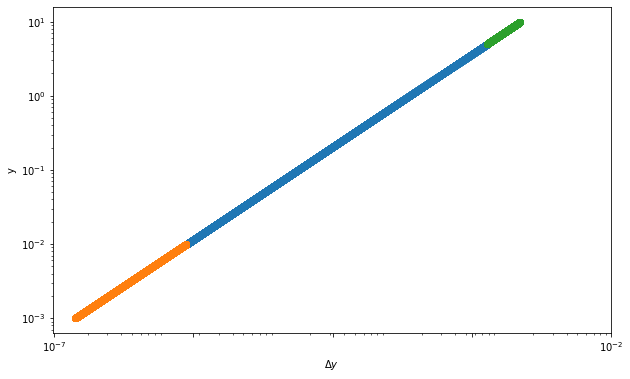

In [5]:
## fitting a logspace for y grid points 

ys1 = np.logspace(-2, np.log10(5), 40000)
ys2 = np.logspace(-3, -2, 15000)
ys3 = np.logspace(np.log10(5), 1, 4500)
print(len(ys), len(ys2))

dys1 = [ ys1[i+1] - ys1[i] for i in range(len(ys1) -1 )]
dys2 = [ ys2[i+1] - ys2[i] for i in range(len(ys2) -1 )]
dys3 = [ ys3[i+1] - ys3[i] for i in range(len(ys3) -1 )]

# plt.scatter(ys[:-1], dys)
# plt.scatter(ys2[:-1], dys2)

fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(dys1, ys1[:-1])
plt.scatter(dys2, ys2[:-1])
plt.scatter(dys3, ys3[:-1])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\Delta y$')
plt.ylabel('y')
plt.xticks(np.logspace(-7, -2, 5))
# plt.xlim(1e-8, 3e-2)
plt.show()

7502 6000


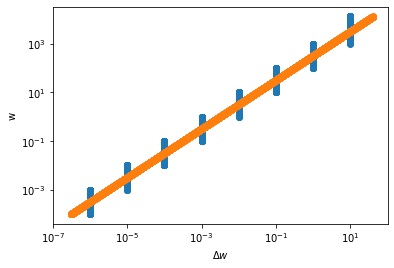

In [6]:
## fitting a logspace for w grid points 

# ws_regs = [np.arange(1e-4, 1e-3, 5e-6),
# np.arange(1e-3, 1e-2, 5e-5),
# np.arange(1e-2, 1e-1, 5e-4),
# np.arange(1e-1, 1e-0, 5e-3),
# np.arange(1e-0, 1e1, 5e-2),
# np.arange(1e1, 1e2, 5e-1),
# np.arange(1e2, 1e3, 5e0),
# np.arange(1e3, 1.3e4+5e1, 5e1)]
# ws = np.concatenate(ws_regs)

ws_regs = [np.arange(1e-4, 1e-3, 1e-6),
np.arange(1e-3, 1e-2, 1e-5),
np.arange(1e-2, 1e-1, 1e-4),
np.arange(1e-1, 1e-0, 1e-3),
np.arange(1e-0, 1e1, 1e-2),
np.arange(1e1, 1e2, 1e-1),
np.arange(1e2, 1e3, 1e0),
np.arange(1e3, 1.3e4+1e1, 1e1)]
ws = np.concatenate(ws_regs)

ws2 = np.logspace(-4, np.log10(1.3e4), 6000)

print(len(ws), len(ws2))

dws = [ ws[i+1] - ws[i] for i in range(len(ws) -1 )]
dws2 = [ ws2[i+1] - ws2[i] for i in range(len(ws2) -1 )]

# plt.scatter(ys[:-1], dys)
# plt.scatter(ys2[:-1], dys2)
plt.scatter(dws, ws[:-1])
plt.scatter(dws2, ws2[:-1])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\Delta w$')
plt.ylabel('w')
plt.xlim(1e-7, 1e2)
plt.show()

In [21]:
ys = np.logspace(np.log10(5), np.log10(10.1), 4500)[1:]
ys[-1]

10.100000000000001

In [15]:
### Grid Generation ###

ws_min, ws_max = 1e-4, 1.3e4

ys = np.logspace(np.log10(5), np.log10(10.1), 4500)[1:]
ws = np.logspace(np.log10(ws_min), np.log10(ws_max), 6000)

y_w_grid = []   #np.array([None]*len(input_prms))
for y in ys[:]:
    if y>0.01:
        wc = pnt_lens_cy.wc_geo_re1p0(y)
    else:
        wc = ws_max
    tmp_ws = ws[ws<=1.1*wc]
    y_w_grid.append([y, tmp_ws])
    
y_w_grid = np.array(y_w_grid, dtype=object)     
grid_num =  np.sum([len(y_w_grid[i][1]) for i in range(len(y_w_grid))])

print('ys: ({:.3f}, {:.3f}), len(ys)={}'.format(ys[0], ys[-1], len(ys)))
print('ws: ({:.4f}, {:2f}), max_len(ws)={}'.format(ws[0], ws[-1], len(ws)))
print('Total points in grid: ', grid_num)

ys: (5.001, 10.100), len(ys)=4499
ws: (0.0001, 13000.000000), max_len(ws)=6000
Total points in grid:  13302458


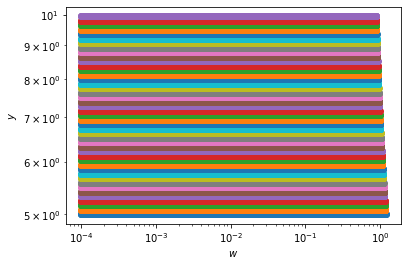

In [25]:
for grids in y_w_grid[::100]:
    plt.scatter(grids[1], [grids[0]]*len(grids[1]))

plt.xscale('log') 
plt.yscale('log') 
plt.xlabel('$w$')
plt.ylabel('$y$')
plt.show()

## 4. Generating the lookup table

In [1]:
import pickle

outdir='../data/'
label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0_ys_5_10'

if __name__=='__main__': 
    npool = 3
    pool = mp.Pool(processes=npool)
    t1=time.time()
    Ff_grid = dict()
    k=0
    for y_ws in tqdm(y_w_grid[:]):
        g_y = y_ws[0]
        g_ws = y_ws[1]
        Ff_eff_partial = partial(pnt_lens_py.point_Fw, y = g_y)
        tmp_res = np.array(list(pool.map(Ff_eff_partial, g_ws)))
        Ff_grid[str(k)] = dict(y=g_y, ws=g_ws, Ffs_real=np.real(tmp_res), Ffs_imag=np.imag(tmp_res))    
        k+=1
    t2 = time.time() 
    print('\nComputation Time (generation) = {:.2f} s'.format(t2-t1))

t1 = time.time()
with open(outdir + label + '.pkl', 'wb') as f:
    pickle.dump(Ff_grid, f)
t2 = time.time() 
print('Computation Time (exporting) = {:.2f} s'.format(t2-t1))  

with open(outdir + label + '.pkl', 'rb') as f:
    Ff_grid = pickle.load(f)

print('\nNumber of entries in lookup_table: ', len(Ff_grid))    

In [118]:
outdir='../data/'
label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0'

with open(outdir + label + '.pkl', 'rb') as f:
    Ff_grid = pickle.load(f)
Ff_grid_1 = Ff_grid
    
outdir='../data/'
label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0_ys_1en3_1en2'

with open(outdir + label + '.pkl', 'rb') as f:
    Ff_grid = pickle.load(f)
Ff_grid_2 = Ff_grid

In [119]:
len(Ff_grid_1), len(Ff_grid_2)

(35000, 14)

In [125]:
Ff_grid_c = dict()

for i in range(len(Ff_grid_2)):
    Ff_grid_c[str(i)] = Ff_grid_2[str(i)]
    
for i in range(len(Ff_grid_1)):
    Ff_grid_c[str(i + len(Ff_grid_2))] = Ff_grid_1[str(i)]    

In [126]:
len(Ff_grid_c)

35014

In [129]:
Ff_grid_c['35013']

{'y': 5.000000000000001,
 'ws': array([1.00000000e-04, 1.00311921e-04, 1.00624816e-04, ...,
        1.17441312e+00, 1.17807637e+00, 1.18175104e+00]),
 'Ffs_real': array([1.00007843, 1.00007868, 1.00007892, ..., 1.03330595, 1.03429526,
        1.03516398]),
 'Ffs_imag': array([-0.00030347, -0.00030426, -0.00030505, ..., -0.01726775,
        -0.01526243, -0.01319419])}

In [ ]:
import numpy as np
import pickle

outdir='../data/'
label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0'

with open(outdir + label + '.pkl', 'rb') as f:
    Ff_grid = pickle.load(f)
Ff_grid_1 = Ff_grid
    
outdir='../data/'
label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0_ys_1en3_1en2'

with open(outdir + label + '.pkl', 'rb') as f:
    Ff_grid = pickle.load(f)
Ff_grid_2 = Ff_grid


Ff_grid_c = dict()

for i in range(len(Ff_grid_2)):
    Ff_grid_c[str(i)] = Ff_grid_2[str(i)]
    
for i in range(len(Ff_grid_1)):
    Ff_grid_c[str(i + len(Ff_grid_2))] = Ff_grid_1[str(i)]

label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0_Mlz_1e-1_1e5_ys_1e-3_5'    
with open(outdir + label + '.pkl', 'wb') as f:
    pickle.dump(Ff_grid_c, f)    
with open(outdir + label + '.pkl', 'rb') as f:
    Ff_grid = pickle.load(f)    
print('\nNumber of entries in lookup_table: ', len(Ff_grid))      

In [2]:
#!/home/anuj.mishra/anaconda3/envs/gwpy/bin/python

import numpy as np

import sys
import mpmath
from mpmath import hyp1f1
import math
import scipy
import pandas as pd

from copy import deepcopy

from itertools import product
from functools import partial
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import pickle

sys.path.append('../src/')
# loading Python version of the point lens class
import pnt_lens_class 
pnt_lens_py = pnt_lens_class.point_lens()

# loading Cython version of the point lens class
import cythonized_pnt_lens_class as pnt_lens_cy


import multiprocessing as mp
npool = 1  # int(sys.argv[1])


G = 6.67430*1e-11 
c = 299792458. 
M_sun = 1.989*1e30


### Grid Generation ###

ws_min, ws_max = 1e-4, 1.3e4

ys = np.logspace(np.log10(5), np.log10(10.1), 4500)[1:]
ws = np.logspace(np.log10(ws_min), np.log10(ws_max), 6000)

y_w_grid = []   #np.array([None]*len(input_prms))
for y in ys[:]:
    if y>0.01:
        wc = pnt_lens_cy.wc_geo_re1p0(y)
    else:
        wc = ws_max
    tmp_ws = ws[ws<=1.1*wc]
    y_w_grid.append([y, tmp_ws])
    
y_w_grid = np.array(y_w_grid, dtype=object)     
grid_num =  np.sum([len(y_w_grid[i][1]) for i in range(len(y_w_grid))])

print('ys: ({:.3f}, {:.3f}), len(ys)={}'.format(ys[0], ys[-1], len(ys)))
print('ws: ({:.4f}, {:2f}), max_len(ws)={}'.format(ws[0], ws[-1], len(ws)))
print('Total points in grid: ', grid_num)


## lookup_table generation
import pickle

outdir='../data/'
label = 'point_lens_Ff_lookup_table_Geo_relErr_1p0_ys_5_10'

if __name__=='__main__': 
    npool = 3
    pool = mp.Pool(processes=npool)
    t1=time.time()
    Ff_grid = dict()
    k=0
    for y_ws in tqdm(y_w_grid[:10]):
        g_y = y_ws[0]
        g_ws = y_ws[1]
        Ff_eff_partial = partial(pnt_lens_py.point_Fw, y = g_y)
        tmp_res = np.array(list(pool.map(Ff_eff_partial, g_ws)))
        Ff_grid[str(k)] = dict(y=g_y, ws=g_ws, Ffs_real=np.real(tmp_res), Ffs_imag=np.imag(tmp_res))    
        k+=1
    t2 = time.time() 
    print('\nComputation Time (generation) = {:.2f} s'.format(t2-t1))

t1 = time.time()
with open(outdir + label + '.pkl', 'wb') as f:
    pickle.dump(Ff_grid, f)
t2 = time.time() 
print('Computation Time (exporting) = {:.2f} s'.format(t2-t1))  

with open(outdir + label + '.pkl', 'rb') as f:
    Ff_grid = pickle.load(f)

print('\nNumber of entries in lookup_table: ', len(Ff_grid))    

ys: (5.001, 10.100), len(ys)=4499
ws: (0.0001, 13000.000000), max_len(ws)=6000
Total points in grid:  13302458


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.05it/s]


Computation Time (generation) = 3.28 s
Computation Time (exporting) = 0.00 s

Number of entries in lookup_table:  10
